In [223]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import to_categorical

<b> About FMCW Radar </b>



In [224]:
dataset_dir = r''

label_map = {'Cars': 0, 
          'Drones': 1, 
          'People': 2}

labels = ['Cars', 'Drones', 'People']

inverse_label_map = {v: k for k, v in label_map.items()}

<b>Labeling Data</b>

The first step of this project is to label the data obtained from the Real Doppler RAD-DAR database. To label the data, we grab each individual folder (Cars, Drones, People) and iterate through every CSV file, reading them, and inserting the matrix of the Range-Doppler plot and the label of either Car, Drone, or Person into a pandas dataframe for easy visualizations of the data.

In [225]:
# Initialize X and Y variables for our neural network
x = []
y = []

# Loop through all classes to label
for idx, label in enumerate(label_map):
    # Ensure the folders exist, do not proceed otherwise
    if os.path.exists(os.path.join(dataset_dir, label)):
        # Walk through the primary directory
        for root, dirs, files in os.walk(os.path.join(dataset_dir, label)):

            # Get all files in the primary directory
            for file in files:

                # Print file paths to ensure we are getting all data
                #print(os.path.join(root,file))

                # Ensure that all data files are CSV
                if file.endswith('.csv'):

                    # Read each CSV file into a DataFrame
                    x_vals = pd.read_csv(os.path.join(root, file), sep=',', header=None)

                    # Convert the DataFrame to a list of lists (matrix)
                    x_mat = x_vals.values.tolist()

                    # Append the matrix to the list
                    x.append(x_mat)

                    # Append the corresponding label
                    y.append(label_map[label])
    else:
        # Throw an error if the folder path doesn't exist
        print('Folder path does not exist or is not in the correct location.')

# Create a new DataFrame with the matrices and labels
data = pd.DataFrame({'data': x, 'label': y})

# Create a CSV so that you don't have to run this process multiple times - it takes a few minutes to run.
data.to_csv('FMCW_Dataset.csv', index=False)  

data

,data,label
0,"[[-113.9, -109.06, -109.85, -117.79, -120.07, ...",0
1,"[[-108.0, -108.24, -117.65, -113.07, -110.86, ...",0
2,"[[-120.74, -118.01, -110.77, -109.12, -110.09,...",0
3,"[[-112.61, -116.09, -117.45, -119.48, -114.56,...",0
4,"[[-111.45, -112.9, -118.35, -117.33, -116.81, ...",0
...,...,...
17480,"[[-108.39, -108.35, -111.52, -109.35, -109.13,...",2
17481,"[[-111.46, -121.63, -114.69, -110.46, -110.24,...",2
17482,"[[-112.59, -108.23, -111.65, -130.53, -118.82,...",2
17483,"[[-109.86, -109.91, -108.41, -116.2, -107.11, ...",2


<b> Loading Data </b>

Now that the data has been saved, we need to reload the data back in.

In [222]:
#data = pd.read_csv('FMCW_Dataset.csv')
#data

,data,label
0,"[[-113.9, -109.06, -109.85, -117.79, -120.07, ...",0
1,"[[-108.0, -108.24, -117.65, -113.07, -110.86, ...",0
2,"[[-120.74, -118.01, -110.77, -109.12, -110.09,...",0
3,"[[-112.61, -116.09, -117.45, -119.48, -114.56,...",0
4,"[[-111.45, -112.9, -118.35, -117.33, -116.81, ...",0
...,...,...
17480,"[[-108.39, -108.35, -111.52, -109.35, -109.13,...",2
17481,"[[-111.46, -121.63, -114.69, -110.46, -110.24,...",2
17482,"[[-112.59, -108.23, -111.65, -130.53, -118.82,...",2
17483,"[[-109.86, -109.91, -108.41, -116.2, -107.11, ...",2


<b> Data Observations </b>

For the most part, these images look distinctive in nature, pointing to the fact that training should be largely accurate.

- The distance-doppler map for people creates a large side-echo on the left portion of the map, which should serve as a indicator that people should be easily distinguishable. 
<br>
</br>
- Cars and drones can have similar distance-doppler maps, if there are small inaccuraries, it would be safe to expect them to be between cars and drones.
<br>
</br>
- It can however be said that drones produce the smallest footprint with generally lower power values.

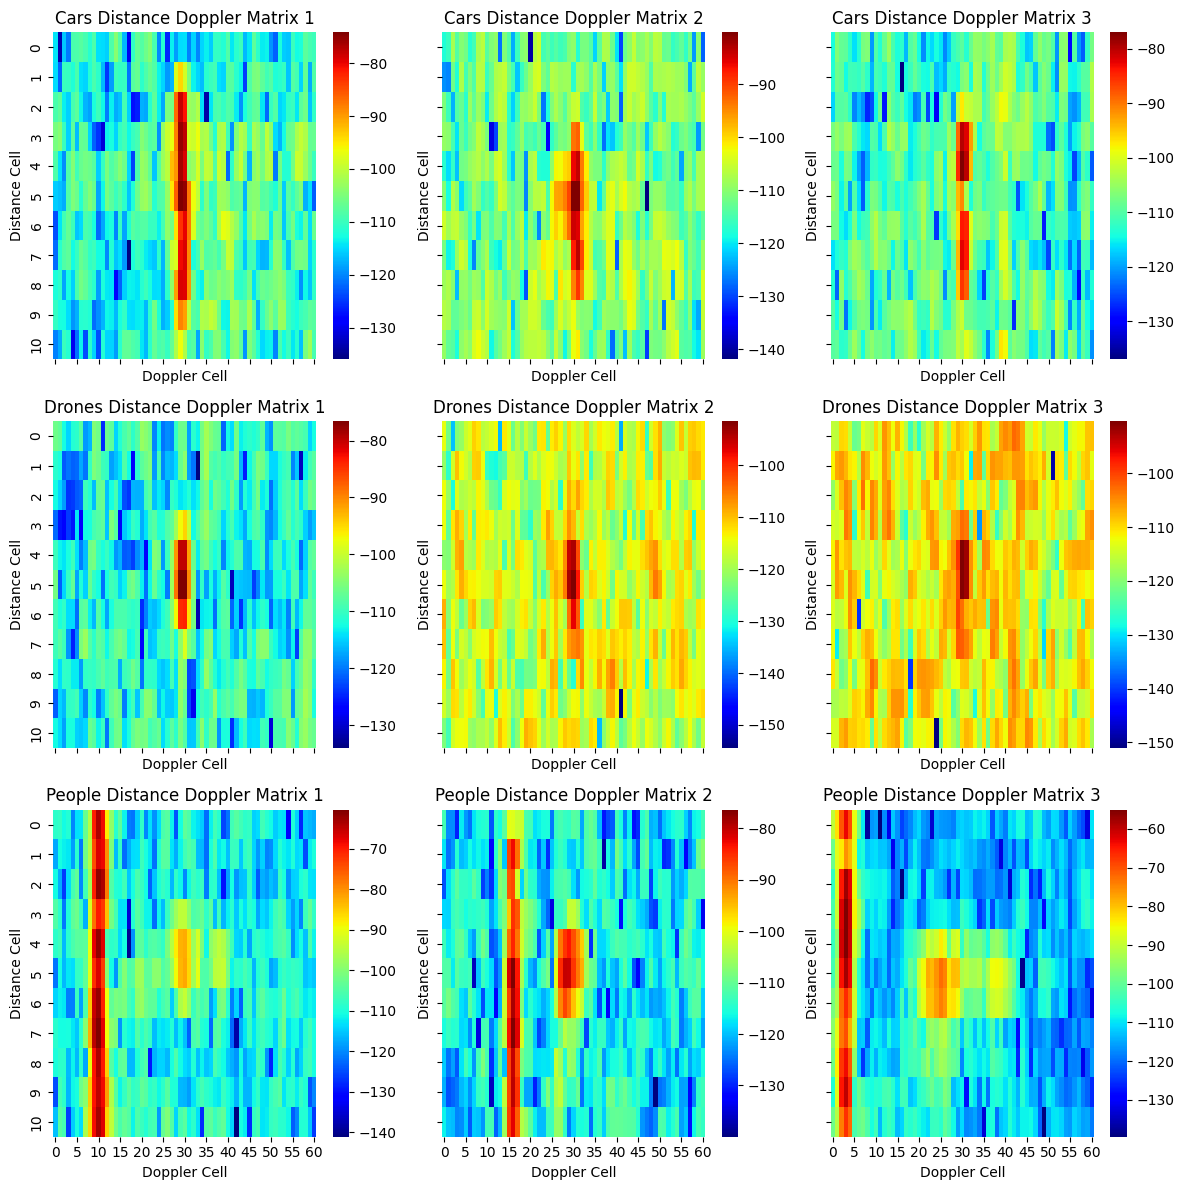

In [226]:
# Create a figure with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

# Loop through the labels
for idx, label in enumerate(label_map):
    # Filter the DataFrame to get rows with labels 0, 1, and 2
    filtered_data = data[data['label'] == idx]

    # Randomly sample three rows from the filtered DataFrame
    random_samples = filtered_data.sample(n=3)
    # Reset index to 0 for each sample, for easy indexing and extraction
    random_samples = random_samples.reset_index(drop=True)
    
    # Loop through the three samples and plot each one in a different subplot
    for j in range(3):
        # Extract the matrix from the DataFrame
        matrix = random_samples.data.iloc[j]
        
        # Calculate the subplot position
        subplot_idx = idx * 3 + j
        row, col = divmod(subplot_idx, 3)
        
        # Plot the heatmap in the corresponding subplot
        sns.heatmap(matrix, ax=axes[row, col], cmap="jet", cbar=True)
        
        # Set titles and labels
        axes[row, col].set_title(f'{label} Distance Doppler Matrix {j+1}')
        axes[row, col].set_xlabel('Doppler Cell')
        axes[row, col].set_ylabel('Distance Cell')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

<b> Gaussian Noise </b>

Adding Gaussian Noise to the Doppler Matrix can be a great way to better generalize the model, as well as increase practicality of the application. Adding Gaussian Noise is a common augmentation technique for computer vision and image processing tasks in the machine learning domain.

Gaussian noise is the probability density function equal to the Gaussian distribution. In essence, the values in the noise are Gaussian-distributed. The formula for gaussian noise is shown below. Numpy conveniently offers a function to take the normal distribution. 

<br>
</br>
<center>
$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(x - \mu)^2}{2 \sigma^2} \right)$
</center>


In [145]:
# Gaussian Noise Parameters
mean = 0 
std_percentage = 0.01
# Percentage of data that will be noisy (i.e. 0.1 for 10%)
percent_noise = 0.1

# Get the total number of data samples
num_samples = data.shape[0]
# Get the fraction as an integer of the noisy samples
num_noisy_samples = int(num_samples * percent_noise)
    
# Randomly sample a percentage of the data based on percent_noise
noisy_samples = data.sample(n=num_noisy_samples)

# Calculate the standard deviation and noise    
std = std_percentage * np.std(data)
noise = np.random.normal(mean, std)  # Shape for a single sample's noise

# Optional printing of noise value
#print(noise)
    
# Iterate through the noisy samples, don't reset index to make it easy to directly add back to the primary dataframe
for index, row in noisy_samples.iterrows():
    data.at[index, 'data'] = row['data'] + noise
    # For plotting purposes
    noisy_samples.at[index, 'data'] = row['data'] + noise

data

c:\users\lcyps\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3571: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,data,label
0,"[[-113.9, -109.06, -109.85, -117.79, -120.07, ...",0
1,"[[-108.0, -108.24, -117.65, -113.07, -110.86, ...",0
2,"[[-120.73987108370257, -118.00987108370258, -1...",0
3,"[[-112.61, -116.09, -117.45, -119.48, -114.56,...",0
4,"[[-111.45, -112.9, -118.35, -117.33, -116.81, ...",0
...,...,...
17480,"[[-108.39, -108.35, -111.52, -109.35, -109.13,...",2
17481,"[[-111.46, -121.63, -114.69, -110.46, -110.24,...",2
17482,"[[-112.58791524697425, -108.22791524697425, -1...",2
17483,"[[-109.86, -109.91, -108.41, -116.2, -107.11, ...",2


<b> Plotting Noisy Data </b>

Taking a look at some of the noisy data shows that the difference can be large or fairly negligable. 

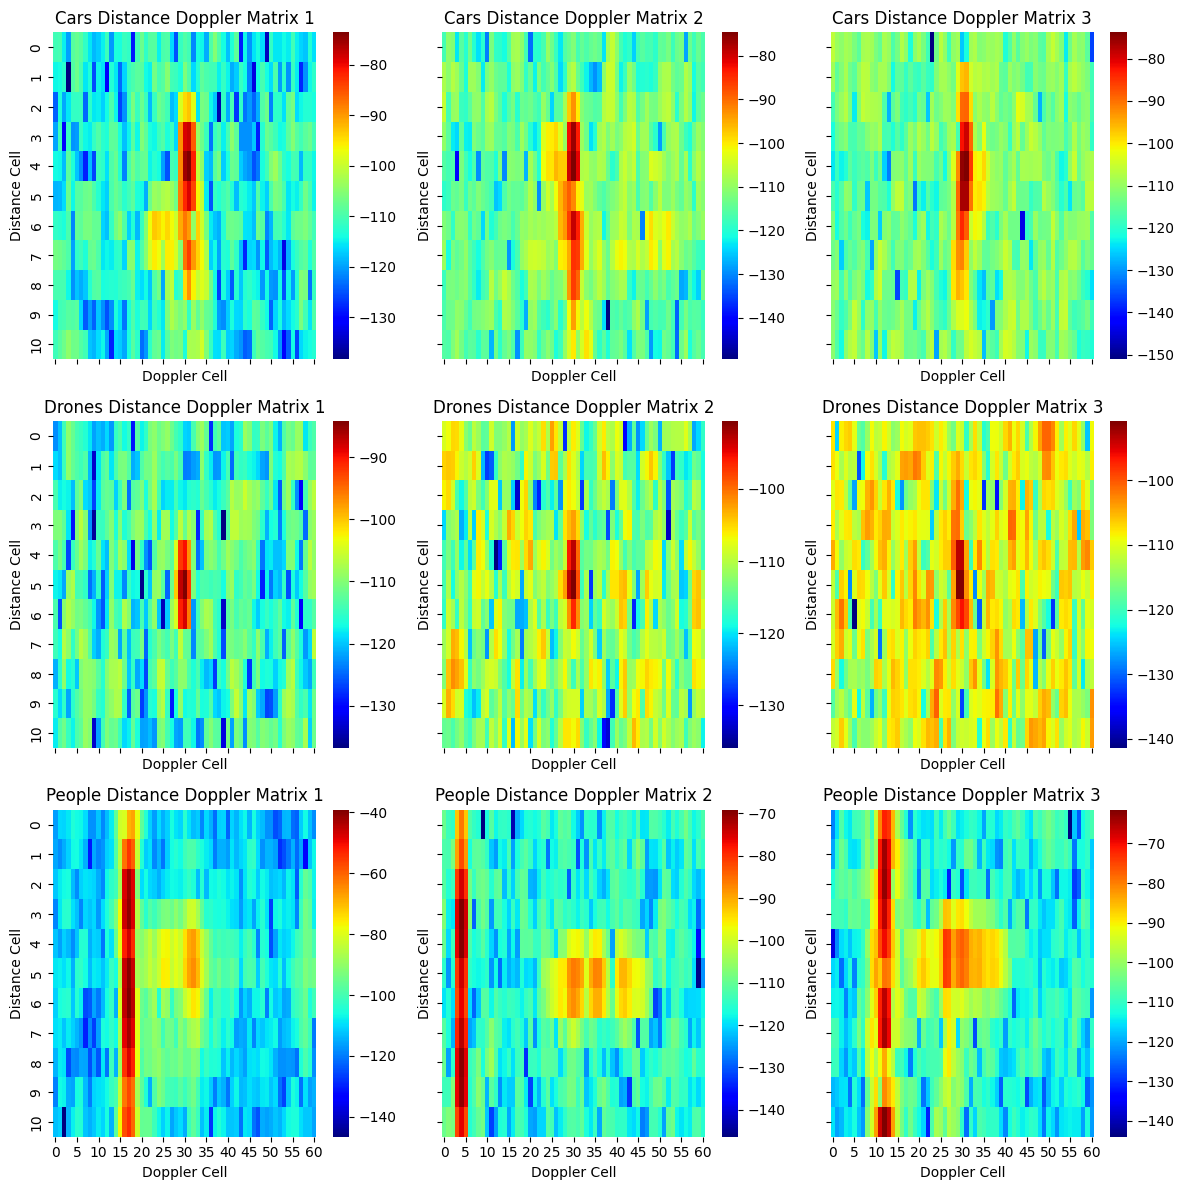

In [146]:
# Create a figure with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

# Loop through the labels
for idx, label in enumerate(label_map):
    # Filter the DataFrame to get rows with labels 0, 1, and 2
    filtered_data = noisy_samples[noisy_samples['label'] == idx]

    # Randomly sample three rows from the filtered DataFrame
    random_samples = filtered_data.sample(n=3)
    # Reset index to 0 for each sample, for easy indexing and extraction
    random_samples = random_samples.reset_index(drop=True)
    
    # Loop through the three samples and plot each one in a different subplot
    for j in range(3):
        # Extract the matrix from the DataFrame
        matrix = random_samples.data.iloc[j]
        
        # Calculate the subplot position
        subplot_idx = idx * 3 + j
        row, col = divmod(subplot_idx, 3)
        
        # Plot the heatmap in the corresponding subplot
        sns.heatmap(matrix, ax=axes[row, col], cmap="jet", cbar=True)
        
        # Set titles and labels
        axes[row, col].set_title(f'{label} Distance Doppler Matrix {j+1}')
        axes[row, col].set_xlabel('Doppler Cell')
        axes[row, col].set_ylabel('Distance Cell')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

<b> Train, Test, & Validation Partioning </b>

An essential step in creating a generalized, non-overfitting model is partioning data into training and testing data, while also saving a small portion of validation data, which is new data the model will never see until it predicts on it after training.

In [227]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.1)

print(train_set.shape)
print(test_set.shape)

(15736, 2)
(1749, 2)


In [228]:
# X train & test are the Distance Doppler Matrix
X_train = np.array(train_set.data.tolist())
X_test = np.array(test_set.data.tolist())

# Should result in (90/10 split of total samples, Distance Cell, Doppler Cell)
print(X_train.shape)
print(X_test.shape)

(15736, 11, 61)
(1749, 11, 61)


In [229]:
# Reshape to fit 2D convolutional neural network shaping requirements
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1], 1)

# (Total Samples, Samples Per Array, Rows Per Array, 1)
print(X_train.shape)
print(X_test.shape)

(15736, 61, 11, 1)
(1749, 61, 11, 1)


In [230]:
train_labels = train_set['label'].tolist()
test_labels = test_set['label'].tolist()


y_train = to_categorical(train_labels, num_classes=len(label_map))
y_test = to_categorical(test_labels, num_classes=len(label_map))

print(y_train.shape)
print(y_test.shape)

(15736, 3)
(1749, 3)


In [239]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_model(input_shape):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    #model.add(layers.MaxPooling2D((2, 2)))

    # Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(len(label_map), activation='softmax'))

    return model

# Create the model
input_shape = (61, 11, 1)
model = create_model(input_shape)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 59, 9, 32)         320       
                                                                 
 flatten_6 (Flatten)         (None, 16992)             0         
                                                                 
 dense_14 (Dense)            (None, 64)                1087552   
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,096,387
Trainable params: 1,096,387
No

In [240]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    verbose = 1,
                    validation_data=(X_test, y_test))

Epoch 1/10
492/492 [==============================] - 9s 15ms/step - loss: 2.5188 - accuracy: 0.7857 - val_loss: 0.2809 - val_accuracy: 0.8977
Epoch 2/10
492/492 [==============================] - 7s 15ms/step - loss: 0.2604 - accuracy: 0.9115 - val_loss: 0.3211 - val_accuracy: 0.8759
Epoch 3/10
492/492 [==============================] - 8s 16ms/step - loss: 0.2162 - accuracy: 0.9264 - val_loss: 0.2194 - val_accuracy: 0.9268
Epoch 4/10
492/492 [==============================] - 7s 15ms/step - loss: 0.1861 - accuracy: 0.9360 - val_loss: 0.2434 - val_accuracy: 0.9200
Epoch 5/10
492/492 [==============================] - 8s 15ms/step - loss: 0.1877 - accuracy: 0.9412 - val_loss: 0.2085 - val_accuracy: 0.9234
Epoch 6/10
492/492 [==============================] - 7s 15ms/step - loss: 0.1639 - accuracy: 0.9463 - val_loss: 0.2320 - val_accuracy: 0.9268
Epoch 7/10
492/492 [==============================] - 8s 15ms/step - loss: 0.1411 - accuracy: 0.9545 - val_loss: 0.2567 - val_accuracy: 0.9245

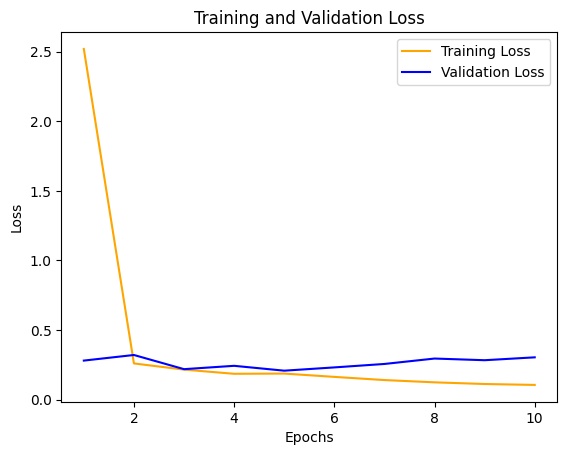

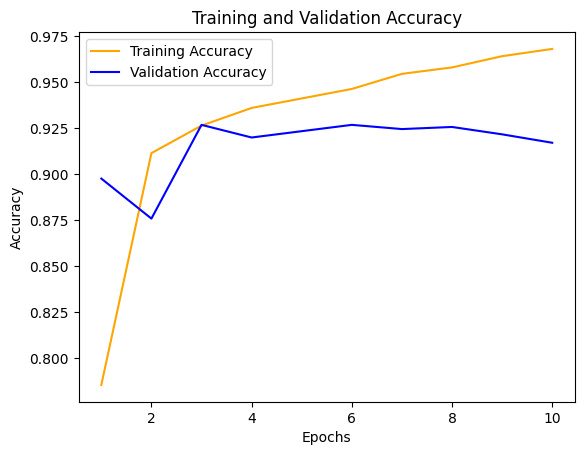

In [241]:
# Take note of the training and validation loss (error) values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Take note of the training and validation accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# The epochs (iterations) are calculated as the length of the collected loss values 
epochs = range(1, len(loss) + 1)

acc_f = round(acc[len(acc)-1], 3) * 100

filename = f"weights_nn_{acc_f}.h5"
model.save(filename)

# Plot Loss
plt.plot(epochs, loss, 'orange', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(epochs, acc, 'orange', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [242]:
test_predictions = model.predict(X_test)

55/55 [==============================] - 0s 5ms/step


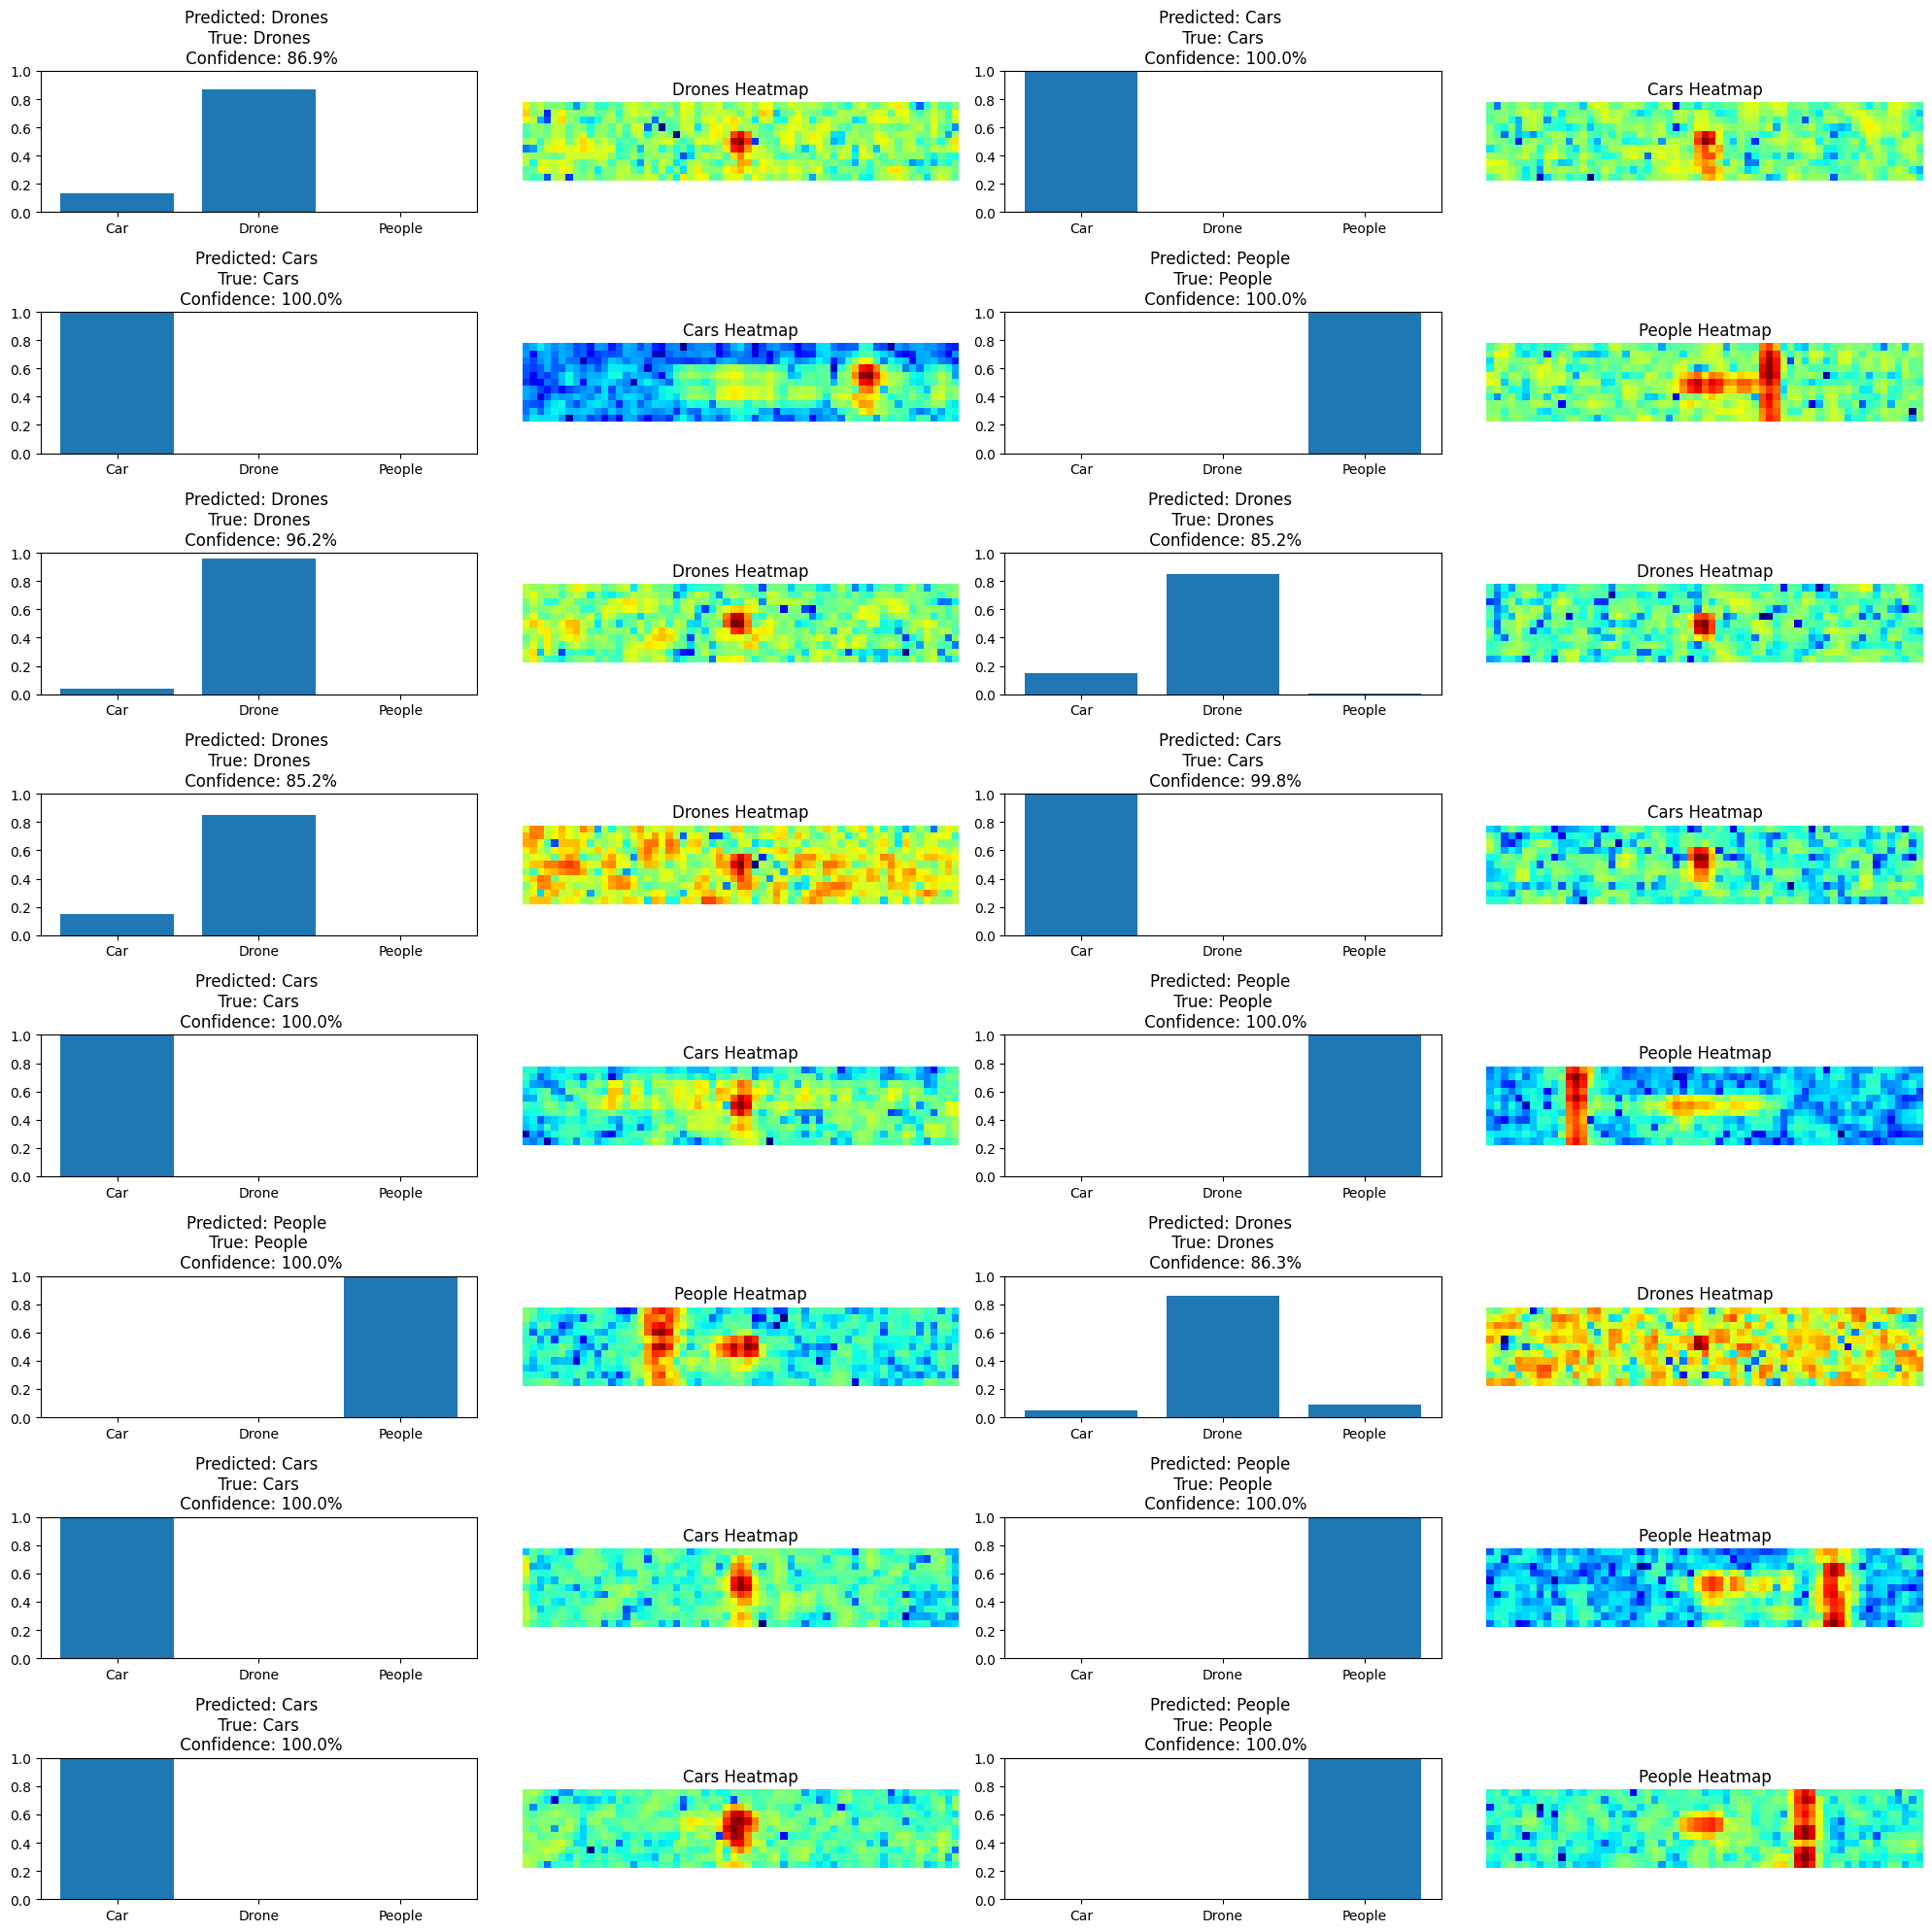

In [256]:
# Graph parameters
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

# Randomly select images
j = np.random.choice(len(X_test), num_images)

# Filter X_test and corresponding labels and predictions
filtered_X_test = X_test[j]
filtered_y_labels = np.array(test_labels)[j]
filtered_predictions = test_predictions[j]

# Create a figure with subplots
fig, axes = plt.subplots(num_rows * 2, num_cols, figsize=(20, 20))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot bar graphs and heatmaps
for idx in range(num_images):
    bar_ax = axes[idx * 2]  # Left column for bar graphs
    heatmap_ax = axes[idx * 2 + 1]  # Right column for heatmaps

    # Plot the bar graph
    bar_ax.bar(['Car', 'Drone', 'People'], filtered_predictions[idx])
    if inverse_label_map[np.argmax(filtered_predictions[idx])] == inverse_label_map[filtered_y_labels[idx]]:
        bar_ax.set_title(f'Predicted: {inverse_label_map[np.argmax(filtered_predictions[idx])]} \n True: {inverse_label_map[filtered_y_labels[idx]]} \n Confidence: {np.max(filtered_predictions[idx]) * 100:.1f}%')
    else:
         bar_ax.set_title(f'Predicted: {inverse_label_map[np.argmax(filtered_predictions[idx])]} \n True: {inverse_label_map[filtered_y_labels[idx]]} \n Confidence: {np.max(filtered_predictions[idx]) * 100:.1f}%', color='red')
    bar_ax.set_ylim(0, 1)  # Adjust the y-axis limit if necessary
    bar_ax.set_xticks(['Car', 'Drone', 'People'])
    bar_ax.set_xticklabels(['Car', 'Drone', 'People'])

    # Plot the heatmap of the image
    sns.heatmap(filtered_X_test[idx].reshape(11, 61), ax=heatmap_ax, cmap='jet', cbar=False, square=True)
    heatmap_ax.set_title(f'{inverse_label_map[filtered_y_labels[idx]]} Heatmap')
    heatmap_ax.axis('off')  # Turn off the axis for the heatmap

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [246]:
test_predictions = model.predict(X_test)

rounded_predictions = []

for idx, ary in enumerate(test_predictions):
    pred = np.argmax(ary)
    rounded_predictions.append(pred)

55/55 [==============================] - 0s 7ms/step


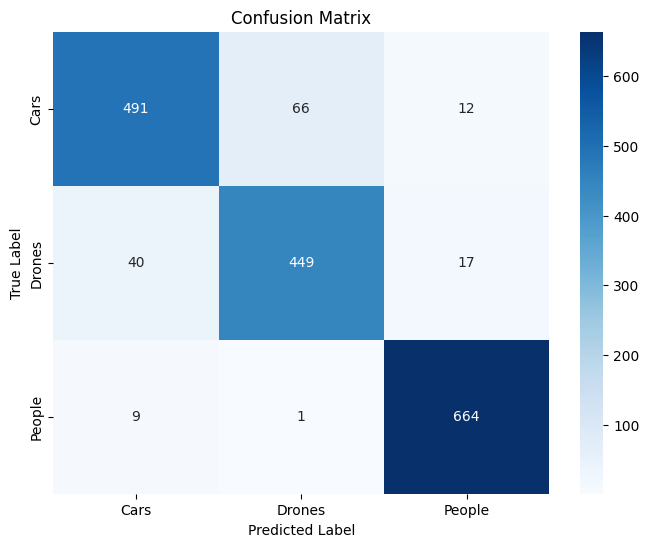

In [247]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(test_labels, rounded_predictions)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()